## Fuel Consumption Forecasting in Homebase Stations
by DT, @2020-10-27

In [118]:
import pandas as pd
import numpy as np
import warnings
import statistics

import plotly.graph_objs as go
import plotly.offline as plotly
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as skpre
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, max_error


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv('../../dataset/data_csv/sis_transa_201801_202007_merged.csv.zip',
                 parse_dates=[['fecha', 'hora']], 
                 compression='zip')

In [4]:
df.columns

Index(['fecha_hora', 'baja_x', 'cantidad', 'codigo_error', 'departamento',
       'fecha_stop', 'geo_latitud', 'geo_longitud', 'geo_status', 'hora_stop',
       'id_bomba', 'id_equipo', 'id_tanque', 'id_transaccion', 'id_usuario',
       'id_vehiculo', 'producto', 'pump_site_id', 'sync', 'tank_site_id',
       'temp_start', 'temp_stop', 'user_site_id', 'veh_site_id', 'veh_tag_id',
       'volume_start', 'volume_stop', 'id_empresa', 'descripcion',
       'ultima_fecha', 'ultima_fecha_h', 'firmware_version', 'baja_x.1',
       'ultima_fecha_sync_db', 'current_firmware', 'ultima_sincronizacion',
       'ultima_conexion', 'delay_ue', 'geo_latitude', 'geo_longitude',
       'id_canal', 'empresa', 'baja_y', 'segmento', 'baja_y.1', 'main_id'],
      dtype='object')

In [5]:
df.drop(axis=1, columns=['baja_x', 'fecha_stop', 'geo_latitud', 'geo_longitud', 'geo_status', 
                         'hora_stop', 'pump_site_id', 'sync', 'tank_site_id', 'user_site_id',
                          'veh_site_id', 'veh_tag_id', 'ultima_fecha', 'ultima_fecha_h',
                          'firmware_version', 'baja_x.1', 'ultima_fecha_sync_db', 'current_firmware',
                          'ultima_sincronizacion', 'ultima_conexion', 'delay_ue', 'geo_latitude',
                          'geo_longitude', 'id_canal', 'baja_y', 'baja_y.1'], inplace=True)

In [6]:
df.isna().sum()

fecha_hora              0
cantidad                0
codigo_error            0
departamento            0
id_bomba                0
id_equipo               0
id_tanque               0
id_transaccion          0
id_usuario              0
id_vehiculo             0
producto             9809
temp_start        1071581
temp_stop         1071581
volume_start      1071581
volume_stop       1071581
id_empresa              0
descripcion             0
empresa                 0
segmento                0
main_id            268724
dtype: int64

In [7]:
df[df['segmento']=='t']['producto'].isna().sum()

4

In [8]:
df.head()

fecha_hora  cantidad codigo_error departamento  id_bomba  \
0 2018-01-01 08:27:00   115.972           BF         0000       174   
1 2018-01-01 13:56:00   127.907           BF         0000       174   
2 2018-01-01 16:54:00    65.571           BF         0000       174   
3 2018-01-01 20:38:00    71.701           BF         0000       174   
4 2018-01-01 00:23:00   360.018           C1         0001       100   

   id_equipo  id_tanque  id_transaccion  id_usuario  id_vehiculo  producto  \
0        139        134            6974        1045        39920       1.0   
1        139        134            6975        1041        39819       1.0   
2        139        134            6976        1055        39931       1.0   
3        139        134            6977        1047        39922       1.0   
4        111         81            5250         436        41504       1.0   

   temp_start  temp_stop  volume_start  volume_stop  id_empresa  \
0         NaN        NaN           NaN          NaN        43.0   
1         NaN        NaN           NaN          NaN        43.0   
2         NaN        NaN           NaN          NaN        43.0   
3         NaN        NaN           NaN          NaN        43.0   
4         NaN        NaN           NaN          NaN        27.0   

          descripcion             empresa segmento main_id  
0  Coop. San Bernardo  Coop. San Bernardo        c  000005  
1  Coop. San Bernardo  Coop. San Bernardo        c  000002  
2  Coop. San Bernardo  Coop. San Bernardo        c  000016  
3  Coop. San Bernardo  Coop. San Bernardo        c  000007  
4        Cruz del Eje           Sarmiento        t  000355

In [9]:
#df.set_index('fecha_hora', inplace=True)

In [10]:
df.head(1)

fecha_hora  cantidad codigo_error departamento  id_bomba  \
0 2018-01-01 08:27:00   115.972           BF         0000       174   

   id_equipo  id_tanque  id_transaccion  id_usuario  id_vehiculo  producto  \
0        139        134            6974        1045        39920       1.0   

   temp_start  temp_stop  volume_start  volume_stop  id_empresa  \
0         NaN        NaN           NaN          NaN        43.0   

          descripcion             empresa segmento main_id  
0  Coop. San Bernardo  Coop. San Bernardo        c  000005

#### MERGE WITH TANKS, PRODUCTS and CURATIONS

In [11]:
df_products = pd.read_csv('../../dataset/data_csv/fs_asignacion_producto.csv')
df_tanks = pd.read_csv('../../dataset/data_csv/fs_tanques.csv')
df_pumps = pd.read_csv('../../dataset/data_csv/fs_bombas.csv')

In [12]:
df = pd.merge(df, df_products, on=['id_equipo', 'producto'], how='left')

In [13]:
df = pd.merge(df, df_tanks, on=['id_tanque'], how='left')

In [14]:
df.drop(df.loc[:, 'codigo':'ultima_fecha'].columns, axis=1, inplace=True)

In [15]:
df

fecha_hora  cantidad_x codigo_error departamento  id_bomba  \
0       2018-01-01 08:27:00     115.972           BF         0000       174   
1       2018-01-01 13:56:00     127.907           BF         0000       174   
2       2018-01-01 16:54:00      65.571           BF         0000       174   
3       2018-01-01 20:38:00      71.701           BF         0000       174   
4       2018-01-01 00:23:00     360.018           C1         0001       100   
...                     ...         ...          ...          ...       ...   
2990496 2020-07-31 23:47:05      92.407           C1         0000       915   
2990497 2020-07-31 23:55:42      55.568           C1         0001       465   
2990498 2020-07-31 23:53:36      83.843           C1         0001       916   
2990499 2020-07-31 23:58:11      48.896           C1         0001       465   
2990500 2020-07-31 23:56:46      28.932           C1         0001       916   

         id_equipo_x  id_tanque  id_transaccion  id_usuario  id_vehiculo  \
0                139        134            6974        1045        39920   
1                139        134            6975        1041        39819   
2                139        134            6976        1055        39931   
3                139        134            6977        1047        39922   
4                111         81            5250         436        41504   
...              ...        ...             ...         ...          ...   
2990496          453       1133            1141        5997        59961   
2990497          633     101322            8869        6696        68753   
2990498          453     101175            1142        5997        69306   
2990499          633     101322            8870        6696        68724   
2990500          453     101175            1143        5997        69307   

         producto_x  temp_start  temp_stop  volume_start  volume_stop  \
0               1.0         NaN        NaN           NaN          NaN   
1               1.0         NaN        NaN           NaN          NaN   
2               1.0         NaN        NaN           NaN          NaN   
3               1.0         NaN        NaN           NaN          NaN   
4               1.0         NaN        NaN           NaN          NaN   
...             ...         ...        ...           ...          ...   
2990496         0.0         0.0        0.0        -1.000       -1.000   
2990497         0.0        13.3       13.3     26133.144    26100.572   
2990498         1.0         0.0        0.0        -1.000       -1.000   
2990499         0.0        13.3       13.3     26079.496    26079.496   
2990500         1.0         0.0        0.0        -1.000       -1.000   

         id_empresa         descripcion              empresa segmento main_id  \
0              43.0  Coop. San Bernardo   Coop. San Bernardo        c  000005   
1              43.0  Coop. San Bernardo   Coop. San Bernardo        c  000002   
2              43.0  Coop. San Bernardo   Coop. San Bernardo        c  000016   
3              43.0  Coop. San Bernardo   Coop. San Bernardo        c  000007   
4              27.0        Cruz del Eje            Sarmiento        t  000355   
...             ...                 ...                  ...      ...     ...   
2990496       269.0             Miramar  Miramar Estrella UT        a  000574   
2990497       149.0             Cordoba          Urbacordoba        i  001127   
2990498       269.0             Miramar  Miramar Estrella UT        a  000601   
2990499       149.0             Cordoba          Urbacordoba        i  001208   
2990500       269.0             Miramar  Miramar Estrella UT        a  000604   

        nombre_producto  capacidad log_interval  nivel_alarma  alarma  \
0             Product 2  0042000.0         0030           0.0     0.0   
1             Product 2  0042000.0         0030           0.0     0.0   
2             Product 2  0042000.0         0030           0.0     0.0   
3            

In [16]:
df.drop(df.loc[:, 'log_interval':'sync'].columns, axis=1, inplace=True)

In [17]:
df['capacidad'] = df['capacidad'].astype('float')

In [18]:
df.rename(columns={'cantidad_x': 'cantidad'}, inplace=True)
df.rename(columns={'id_equipo_x': 'id_equipo'}, inplace=True)

Se soluciona la comparación de cantidad transaccionada respecto de la capacidad del tanque:

In [19]:
df['capacidad'].isna().sum() ## Detectar sitios mal configurados

32520

In [20]:
df['capacidad'] = df['capacidad'].fillna(110000) #No hay tanques de mas de 100m3 en las instalaciones actuales.

In [21]:
df.loc[df['capacidad']<=1, 'capacidad']=110000.0 #No hay capacidades de 0.0, es falta de configuración

In [22]:
df[ (df['segmento']=='t') & (df['cantidad'] > df['capacidad']) ] ## SE HACE FOCO EN SEGMENTO TRANSPORTE

Empty DataFrame
Columns: [fecha_hora, cantidad, codigo_error, departamento, id_bomba, id_equipo, id_tanque, id_transaccion, id_usuario, id_vehiculo, producto_x, temp_start, temp_stop, volume_start, volume_stop, id_empresa, descripcion, empresa, segmento, main_id, nombre_producto, capacidad]
Index: []

Ver cantidad de transacciones con cantidad cero:

In [23]:
df[ df['cantidad'] == 0 ].shape ##Cantidad de transacciones en cero

(107683, 22)

Transacciones negativas (abastecimientos), no deben ser consideradas en este análisis

In [24]:
df[ df['cantidad']<0 ]

Empty DataFrame
Columns: [fecha_hora, cantidad, codigo_error, departamento, id_bomba, id_equipo, id_tanque, id_transaccion, id_usuario, id_vehiculo, producto_x, temp_start, temp_stop, volume_start, volume_stop, id_empresa, descripcion, empresa, segmento, main_id, nombre_producto, capacidad]
Index: []

### Descriptores de Consumo en Transporte por Sitio

1. Cómo es la distribución de consumos por sitio por mes?

In [25]:
dft1 = df[df['segmento']=='t'].set_index('fecha_hora')

In [26]:
dft1

cantidad codigo_error departamento  id_bomba  id_equipo  \
fecha_hora                                                                     
2018-01-01 00:23:00   360.018           C1         0001       100        111   
2018-01-01 02:28:00   190.230           C1         0001       100        111   
2018-01-01 14:09:00   115.253           BF         0001       100        111   
2018-01-01 16:08:00    21.749           C1         0000        99        111   
2018-01-01 17:28:00    90.549           C1         0000        99        111   
...                       ...          ...          ...       ...        ...   
2020-07-31 23:01:00   240.139           C2         0000       263        189   
2020-07-31 22:33:10    25.757           C4         0001     11452        788   
2020-07-31 23:39:29   138.502           C1         0001     10922        534   
2020-07-31 23:50:21   153.165           C1         0001     10922        534   
2020-07-31 23:56:45   447.055           C4         0000       951        525   

                     id_tanque  id_transaccion  id_usuario  id_vehiculo  \
fecha_hora                                                                
2018-01-01 00:23:00         81            5250         436        41504   
2018-01-01 02:28:00         81            5251         436        41024   
2018-01-01 14:09:00         81            5252         433        41504   
2018-01-01 16:08:00         81            5253         432         1188   
2018-01-01 17:28:00         81            5254         432         1172   
...                        ...             ...         ...          ...   
2020-07-31 23:01:00        282            8618           0       101654   
2020-07-31 22:33:10     101922            1999       12967        92206   
2020-07-31 23:39:29     101099            3415        6210        62038   
2020-07-31 23:50:21     101099            3416        6210        62038   
2020-07-31 23:56:45       1169            6248        6182        73603   

                     producto_x  temp_start  temp_stop  volume_start  \
fecha_hora                                                             
2018-01-01 00:23:00         1.0         NaN        NaN           NaN   
2018-01-01 02:28:00         1.0         NaN        NaN           NaN   
2018-01-01 14:09:00         1.0         NaN        NaN           NaN   
2018-01-01 16:08:00         1.0         NaN        NaN           NaN   
2018-01-01 17:28:00         1.0         NaN        NaN           NaN   
...                         ...         ...        ...           ...   
2020-07-31 23:01:00         0.0         NaN        NaN           NaN   
2020-07-31 22:33:10         1.0        11.8       11.8     31627.762   
2020-07-31 23:39:29         0.0        16.2       16.1      9018.293   
2020-07-31 23:50:21         0.0        16.1       16.2      8914.100   
2020-07-31 23:56:45         0.0         0.0        0.0        -1.000   

                     volume_stop  id_empresa          descripcion  \
fecha_hora                                                          
2018-01-01 00:23:00          NaN        27.0         Cruz del Eje   
2018-01-01 02:28:00          NaN        27.0         Cruz del Eje   
2018-01-01 14:09:00          NaN        27.0         Cruz del Eje   
2018-01-01 16:08:00          NaN        27.0         Cruz del Eje   
2018-01-01 17:28:00          NaN        27.0         Cruz del Eje   
...                          ...         ...                  ...   
2020-07-31 23:01:00          NaN        74.0  Francisco Alvarez 1   
2020-07-31 22:33:10    31605.415       227.0       Zárate Derecho   
2020-07-31 23:39:29     8920.300       273.0            San Justo   
2020-07-31 23:50:21     8797.850       273.0            San Justo   
2020-07-31 23:56:45       -1.000      1066.0                  525   

                                         empresa segmento main_id  \
fecha_hora                                                          
2018-01-01 00:23:00            

In [27]:
aggDict = {'cantidad': 'sum',
           'id_vehiculo': lambda x: x.nunique(),
           'id_tanque': lambda x: x.nunique(),
           'id_transaccion': 'count'
          }

In [28]:
dft1a = dft1.groupby('id_equipo').resample('M').agg(aggDict).reset_index() ## Cantidad mensual de consumo por sitio y vehiculos

In [29]:
dft1a['cantxVeh'] = dft1a['cantidad']/dft1a['id_vehiculo']
dft1a['cantxTran'] = dft1a['cantidad']/dft1a['id_transaccion']
dft1a['tranxVeh'] = dft1a['id_transaccion']/dft1a['id_vehiculo']

In [30]:
dft1a['id_equipo'] = dft1a['id_equipo'].astype('category')

In [31]:
dft1a['site_monthly_mean'] = dft1a.groupby('id_equipo')['cantidad'].transform('mean')

In [32]:
#dft1a = dft1a.sort_values('site_monthly_mean').reset_index(drop=True)
dft1a

id_equipo fecha_hora   cantidad  id_vehiculo  id_tanque  id_transaccion  \
0          100 2018-01-31  55541.255           47          1             507   
1          100 2018-02-28  45456.281           37          1             355   
2          100 2018-03-31  71650.498           46          1             606   
3          100 2018-04-30  75676.573           49          1             629   
4          100 2018-05-31  82378.331           48          1             727   
...        ...        ...        ...          ...        ...             ...   
2639       821 2020-05-31      0.145            2          1               6   
2640       821 2020-06-30   1127.368            2          1              63   
2641       821 2020-07-31   9620.023            1          1              52   
2642       831 2020-06-30      0.000            1          1               1   
2643       831 2020-07-31   7000.238            4          2              69   

         cantxVeh   cantxTran   tranxVeh  site_monthly_mean  
0     1181.728830  109.548826  10.787234       59495.616161  
1     1228.548135  128.045862   9.594595       59495.616161  
2     1557.619522  118.235145  13.173913       59495.616161  
3     1544.419857  120.312517  12.836735       59495.616161  
4     1716.215229  113.312697  15.145833       59495.616161  
...           ...         ...        ...                ...  
2639     0.072500    0.024167   3.000000        3582.512000  
2640   563.684000   17.894730  31.500000        3582.512000  
2641  9620.023000  185.000442  52.000000        3582.512000  
2642     0.000000    0.000000   1.000000        3500.119000  
2643  1750.059500  101.452725  17.250000        3500.119000  

[2644 rows x 10 columns]

In [33]:
le = skpre.LabelEncoder()
le.fit(dft1a['id_equipo'])
dft1a['site'] = le.transform(dft1a['id_equipo'])

In [34]:
dft1a

id_equipo fecha_hora   cantidad  id_vehiculo  id_tanque  id_transaccion  \
0          100 2018-01-31  55541.255           47          1             507   
1          100 2018-02-28  45456.281           37          1             355   
2          100 2018-03-31  71650.498           46          1             606   
3          100 2018-04-30  75676.573           49          1             629   
4          100 2018-05-31  82378.331           48          1             727   
...        ...        ...        ...          ...        ...             ...   
2639       821 2020-05-31      0.145            2          1               6   
2640       821 2020-06-30   1127.368            2          1              63   
2641       821 2020-07-31   9620.023            1          1              52   
2642       831 2020-06-30      0.000            1          1               1   
2643       831 2020-07-31   7000.238            4          2              69   

         cantxVeh   cantxTran   tranxVeh  site_monthly_mean  site  
0     1181.728830  109.548826  10.787234       59495.616161     0  
1     1228.548135  128.045862   9.594595       59495.616161     0  
2     1557.619522  118.235145  13.173913       59495.616161     0  
3     1544.419857  120.312517  12.836735       59495.616161     0  
4     1716.215229  113.312697  15.145833       59495.616161     0  
...           ...         ...        ...                ...   ...  
2639     0.072500    0.024167   3.000000        3582.512000   115  
2640   563.684000   17.894730  31.500000        3582.512000   115  
2641  9620.023000  185.000442  52.000000        3582.512000   115  
2642     0.000000    0.000000   1.000000        3500.119000   116  
2643  1750.059500  101.452725  17.250000        3500.119000   116  

[2644 rows x 11 columns]

In [35]:
fig = go.Figure()
fig.add_trace(go.Box(x=dft1a['site'], 
                     y=dft1a['cantidad'],
                     boxpoints=False,
                     notched=False,
                     marker_color = 'lightseagreen'
                    ))

fig.add_trace(go.Scatter(x=dft1a['site'], 
                         y=dft1a['site_monthly_mean'],
                         mode='markers',
                        ))

fig.update_layout(title='Consumo Mensual de Combustible en Transporte por Centro Operativo',
                  title_x = 0.5,
                  #autosize=False,
                  #width=1000,
                  #height=1000,
                  
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(zeroline=False, gridcolor='white', tickmode='linear', dtick=100000, tick0=0),
                  
                  xaxis_title="Centros Operativos [Sites]",
                  yaxis_title="Litros Mensuales Consumidos [Lts]",
                  
                  legend_title="Legend Title",
                  
                
                  font=dict(size=14,
                            #color="RebeccaPurple"
                           ),
                  #paper_bgcolor='rgb(233,233,233)',
                  #plot_bgcolor='rgb(233,233,233)',
                 )

fig.show()
#fig.write_html('./images/fig1.html')

In [36]:
#fig.write_html('./images/fig1.html')

### Histograms

In [37]:
dft1b = dft1a.groupby('id_equipo')['cantidad'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
dft1b

mean       median           std         min         max  \
id_equipo                                                                     
100         59495.616161   55191.0650  26332.136373   17335.005  123575.689   
102         81629.759226   83896.4180   8858.957046   61908.263   95089.465   
106          9904.374000    6680.3820   8549.466299      92.549   25167.164   
111         99781.876929  103451.3825  20237.329680    6103.822  115265.006   
115        138916.004250  147013.1105  27725.232909   82104.359  165902.766   
...                  ...          ...           ...         ...         ...   
761           100.770000     100.7700           NaN     100.770     100.770   
788         76319.869143   86941.0250  31861.890963   22740.851  120993.365   
820        208507.680000  208507.6800           NaN  208507.680  208507.680   
821          3582.512000    1127.3680   5258.926909       0.145    9620.023   
831          3500.119000    3500.1190   4949.915760       0.000    7000.238   

           count  
id_equipo         
100           31  
102           31  
106           31  
111           28  
115           12  
...          ...  
761            1  
788            7  
820            1  
821            3  
831            2  

[117 rows x 6 columns]

In [38]:
fig = px.histogram(dft1b, x='mean', marginal='box')
fig.update_layout(title='Histograma de Consumos Mensuales en Transporte',
                  title_x = 0.1,
                  #autosize=False,
                  #width=1000,
                  #height=1000,
    
                  #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  xaxis=dict(zeroline=False, gridcolor='white', tickmode='linear', dtick=25000, tick0=0),
                  
                  xaxis_title="Litros Mensuales Consumidos [Lts]",
                  yaxis_title="Centros Operativos [Sites]",
                
                  font=dict(size=14,
                            #color="RebeccaPurple"
                           ),
                  #paper_bgcolor='rgb(233,233,233)',
                  #plot_bgcolor='rgb(233,233,233)',
                 )
fig.show()

In [39]:
#fig.write_html('./images/Histogram_Monthly_Consumption_per_Site.html')

In [40]:
dft1c = dft1a.groupby('id_equipo').agg({'cantidad': 'median', 
                                        'id_vehiculo': 'median',
                                        'id_transaccion': 'median',
                                        'id_tanque': 'median'
                                       })
dft1c

cantidad  id_vehiculo  id_transaccion  id_tanque
id_equipo                                                     
100         55191.0650         43.0           426.0        1.0
102         83896.4180         76.0           821.0        1.0
106          6680.3820          2.0            16.0        1.0
111        103451.3825         49.0           923.0        1.0
115        147013.1105          6.0           769.0        1.0
...                ...          ...             ...        ...
761           100.7700          3.0            15.0        1.0
788         86941.0250         60.0           286.0        1.0
820        208507.6800        243.0           400.0        3.0
821          1127.3680          2.0            52.0        1.0
831          3500.1190          2.5            35.0        1.5

[117 rows x 4 columns]

In [41]:
fig = px.scatter(dft1c, 
                 x='cantidad', 
                 y='id_vehiculo', 
                 marginal_x="box", 
                 marginal_y="box")

fig.update_layout(title='Relación entre Consumo y Cantidad de Unidades de Consumo',
                  title_x = 0.1,
                  #autosize=False,
                  #width=1000,
                  #height=1000,
    
                  #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  xaxis=dict(zeroline=False, gridcolor='white', tickmode='linear', dtick=25000, tick0=0),
                  
                  xaxis_title="Litros Mensuales Consumidos [Lts]",
                  yaxis_title="Unidades de Consumo [Qy]",
                
                  font=dict(size=14,
                            #color="RebeccaPurple"
                           ),
                  #paper_bgcolor='rgb(233,233,233)',
                  #plot_bgcolor='rgb(233,233,233)',
                 )


fig.show()

In [42]:
#fig.write_html('./images/Relación entre Consumos y Unidades.html')

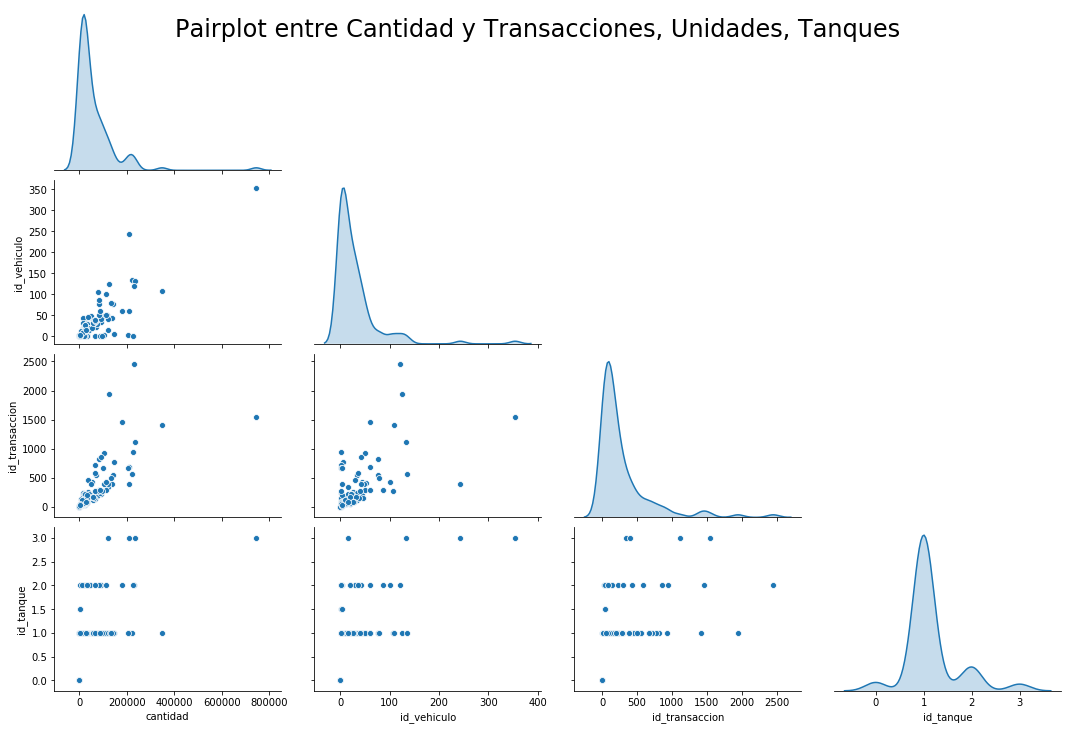

In [43]:
f = sns.pairplot(dft1c, diag_kind = 'kde', corner=True)
f.fig.set_figwidth(15)

plt.suptitle('Pairplot entre Cantidad y Transacciones, Unidades, Tanques', size = 24);
#f.savefig('./images/pairplot.png')

#### ANALISIS PERIODICO POR SITIO DE TRANSPORTE

In [44]:
dft1

cantidad codigo_error departamento  id_bomba  id_equipo  \
fecha_hora                                                                     
2018-01-01 00:23:00   360.018           C1         0001       100        111   
2018-01-01 02:28:00   190.230           C1         0001       100        111   
2018-01-01 14:09:00   115.253           BF         0001       100        111   
2018-01-01 16:08:00    21.749           C1         0000        99        111   
2018-01-01 17:28:00    90.549           C1         0000        99        111   
...                       ...          ...          ...       ...        ...   
2020-07-31 23:01:00   240.139           C2         0000       263        189   
2020-07-31 22:33:10    25.757           C4         0001     11452        788   
2020-07-31 23:39:29   138.502           C1         0001     10922        534   
2020-07-31 23:50:21   153.165           C1         0001     10922        534   
2020-07-31 23:56:45   447.055           C4         0000       951        525   

                     id_tanque  id_transaccion  id_usuario  id_vehiculo  \
fecha_hora                                                                
2018-01-01 00:23:00         81            5250         436        41504   
2018-01-01 02:28:00         81            5251         436        41024   
2018-01-01 14:09:00         81            5252         433        41504   
2018-01-01 16:08:00         81            5253         432         1188   
2018-01-01 17:28:00         81            5254         432         1172   
...                        ...             ...         ...          ...   
2020-07-31 23:01:00        282            8618           0       101654   
2020-07-31 22:33:10     101922            1999       12967        92206   
2020-07-31 23:39:29     101099            3415        6210        62038   
2020-07-31 23:50:21     101099            3416        6210        62038   
2020-07-31 23:56:45       1169            6248        6182        73603   

                     producto_x  temp_start  temp_stop  volume_start  \
fecha_hora                                                             
2018-01-01 00:23:00         1.0         NaN        NaN           NaN   
2018-01-01 02:28:00         1.0         NaN        NaN           NaN   
2018-01-01 14:09:00         1.0         NaN        NaN           NaN   
2018-01-01 16:08:00         1.0         NaN        NaN           NaN   
2018-01-01 17:28:00         1.0         NaN        NaN           NaN   
...                         ...         ...        ...           ...   
2020-07-31 23:01:00         0.0         NaN        NaN           NaN   
2020-07-31 22:33:10         1.0        11.8       11.8     31627.762   
2020-07-31 23:39:29         0.0        16.2       16.1      9018.293   
2020-07-31 23:50:21         0.0        16.1       16.2      8914.100   
2020-07-31 23:56:45         0.0         0.0        0.0        -1.000   

                     volume_stop  id_empresa          descripcion  \
fecha_hora                                                          
2018-01-01 00:23:00          NaN        27.0         Cruz del Eje   
2018-01-01 02:28:00          NaN        27.0         Cruz del Eje   
2018-01-01 14:09:00          NaN        27.0         Cruz del Eje   
2018-01-01 16:08:00          NaN        27.0         Cruz del Eje   
2018-01-01 17:28:00          NaN        27.0         Cruz del Eje   
...                          ...         ...                  ...   
2020-07-31 23:01:00          NaN        74.0  Francisco Alvarez 1   
2020-07-31 22:33:10    31605.415       227.0       Zárate Derecho   
2020-07-31 23:39:29     8920.300       273.0            San Justo   
2020-07-31 23:50:21     8797.850       273.0            San Justo   
2020-07-31 23:56:45       -1.000      1066.0                  525   

                                         empresa segmento main_id  \
fecha_hora                                                          
2018-01-01 00:23:00            

In [93]:
dft2 = dft1.groupby('id_equipo').resample('D')['cantidad'].sum()

In [95]:
dft2

id_equipo  fecha_hora
100        2018-01-01    2064.329
           2018-01-02    2925.648
           2018-01-03    2915.974
           2018-01-04    1410.797
           2018-01-05    1534.855
                           ...   
831        2020-07-27       0.000
           2020-07-28    1102.312
           2020-07-29       1.067
           2020-07-30    1500.884
           2020-07-31    4390.216
Name: cantidad, Length: 79003, dtype: float64

In [96]:
dft3 = dft2.unstack('id_equipo').agg(['mean', 'std', 'min'], axis=1) ##FILL VALUE != 0

In [97]:
dft3['date'] = dft3.index.strftime('%Hhs %a, %d/%m/%Y')

In [98]:
dft3

mean          std     min                  date
2018-01-01  1220.997107  1268.292594  32.930  00hs Mon, 01/01/2018
2018-01-02  3292.327358  5864.859597   0.000  00hs Tue, 02/01/2018
2018-01-03  2744.893866  4913.267821   0.000  00hs Wed, 03/01/2018
2018-01-04  3303.626000  5594.536604   0.000  00hs Thu, 04/01/2018
2018-01-05  2519.688060  3333.503021   0.000  00hs Fri, 05/01/2018
...                 ...          ...     ...                   ...
2020-07-27  3526.526855  5158.891205   0.000  00hs Mon, 27/07/2020
2020-07-28  3169.533333  5420.630554   0.000  00hs Tue, 28/07/2020
2020-07-29  3126.923191  4087.669974   0.000  00hs Wed, 29/07/2020
2020-07-30  2934.839868  3638.108467   0.000  00hs Thu, 30/07/2020
2020-07-31  3636.322492  4380.914280   8.626  00hs Fri, 31/07/2020

[943 rows x 4 columns]

In [101]:
def timeFig(df, path):
    fig = go.Figure([
        go.Scatter(
            name='Measurement',
            x = df['date'],
            y = df['mean'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
            showlegend=False,
            #hover_data={"date": "|%B %d, %Y"}
        ),
        go.Scatter(
            name='Upper Bound',
            x = df['date'],
            y = df['mean'] + df['std'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x = df['date'],
            y = df['min'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])

    fig.update_layout(title='Serie temporal de Consumos en Transporte',
                  title_x = 0.25,
                  #autosize=False,
                  #width=1000,
                  #height=1000,
    
                  #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  #yaxis=dict(zeroline=False, gridcolor='white', tickmode='linear', dtick=25000, tick0=0),
                  #yaxis = dict(range=[0, 600], dtick=75, autorange=False),
                  
                  xaxis_title="Tiempo",
                  yaxis_title="Consumo promedio por hora [Lts]",
                  
                  #hovermode="x",
                
                  font=dict(size=14,
                            #color="RebeccaPurple"
                           ),
                  #paper_bgcolor='rgb(233,233,233)',
                  #plot_bgcolor='rgb(233,233,233)',
                 )

    fig.show()
    #fig.write_html(path)

In [102]:
timeFig(dft3, './images/Consumos Promedio por Hora 2018-2020.html')

In [106]:
timeFig(dft3['2020'], './images/Consumos Promedio por Dia 2020.html')

In [107]:
timeFig(dft3['2020-07'], './images/Consumos Promedio por Dia 07-2020.html')

### TIME SERIES FORECASTING OF MEAN CONSUMPTION PER HOUR

In [116]:
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

In [109]:
dft3['mean'].describe()

count     943.000000
mean     2294.847370
std       761.273706
min       505.212275
25%      1830.007389
50%      2547.209025
75%      2865.608316
max      3871.208132
Name: mean, dtype: float64

In [201]:
train = dft3['mean']
train_log = np.log(train)

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [202]:
adfuller(train_log) #adf, pvalue, usedlag_, nobs_, critical_values_, icbest_

(-3.6705552692153613,
 0.004546908437774634,
 21,
 921,
 {'1%': -3.437470108019385,
  '5%': -2.8646832620852853,
  '10%': -2.5684436698650503},
 -116.78692984814097)

Los datos podrían ser estacionarios dado que p-value es muy próximo a cero, rechazando la hipotesis nula.

Ademas, el ADF es -3.43, el cual es igual o menor que la probabilidad del 1% de que sea no-estacionaria.

In [203]:
kpss(train_log, 'ct')

(0.09810235863978546,
 0.1,
 22,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [204]:
fig = go.Figure([
        go.Scatter(
            name='Measurement',
            #x = dft3['date'],
            y = train_log,
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
            showlegend=False
            #hover_data={"date": "|%B %d, %Y"}
        )])
fig.show()

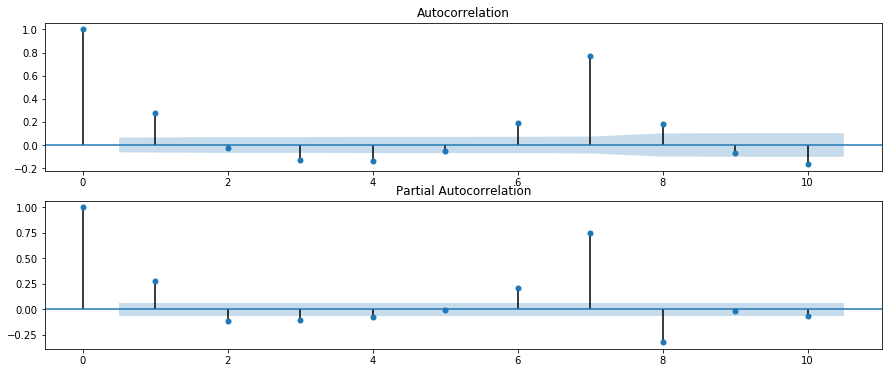

In [261]:
fig, ax = plt.subplots(2,1, figsize=(15,6))
fig = sm.graphics.tsa.plot_acf(train_log, lags=10, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(train_log, lags=10, ax=ax[1])

plt.show()
fig.savefig('./images/ACF-PACF.png')

In [170]:
from statsmodels.tsa.arima_model import ARIMA

In [214]:
model = ARIMA(train_log, (7, 0, 7))
res = model.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                   mean   No. Observations:                  943
Model:                     ARMA(7, 7)   Log Likelihood                 142.355
Method:                       css-mle   S.D. of innovations              0.205
Date:                Wed, 04 Nov 2020   AIC                           -252.710
Time:                        01:13:51   BIC                           -175.125
Sample:                    01-01-2018   HQIC                          -223.139
                         - 07-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6617      0.024    316.984      0.000       7.614       7.709
ar.L1.mean    -0.1371      0.000   -320.435      0.000      -0.138      -0.136
ar.L2.mean    -0.1366      0.000   -605.427      0.0

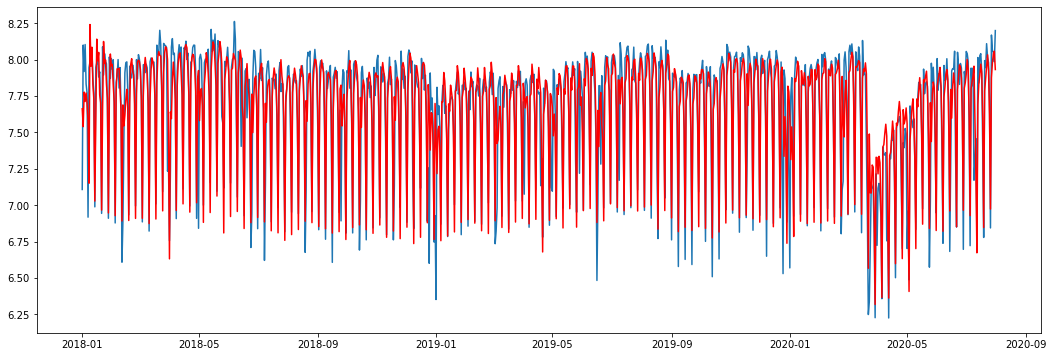

In [217]:
fig = plt.figure(figsize=(18, 6))
plt.plot(train_log)
plt.plot(res.fittedvalues, color='red')

In [219]:
predictions_ARIMA_log = pd.Series(res.fittedvalues, copy=True)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA

2018-01-01    2125.373981
2018-01-02    1879.564911
2018-01-03    2383.053924
2018-01-04    2233.721583
2018-01-05    2369.043019
                 ...     
2020-07-27    2630.495459
2020-07-28    2917.387732
2020-07-29    3098.829896
2020-07-30    3157.441785
2020-07-31    2782.517025
Length: 943, dtype: float64

In [223]:
fig = go.Figure([
        go.Scatter(
            x = dft3['date'],
            y = train,
            mode='lines',
            line=dict(color='blue'),
            showlegend=False
            #hover_data={"date": "|%B %d, %Y"}
        ),
        go.Scatter(
            x = dft3['date'],
            y = predictions_ARIMA,
            mode='lines',
            line=dict(color='red'),
            showlegend=False
            #hover_data={"date": "|%B %d, %Y"}
        )
])

fig.update_layout(title='Serie temporal de Consumos en Transporte y ARIMA Predictor',
                  title_x = 0.1,
                  #autosize=False,
                  #width=1000,
                  #height=1000,
    
                  #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  #yaxis=dict(zeroline=False, gridcolor='white', tickmode='linear', dtick=25000, tick0=0),
                  #yaxis = dict(range=[0, 600], dtick=75, autorange=False),
                  
                  xaxis_title="Tiempo",
                  yaxis_title="Consumo promedio por dia [Lts]",
                  
                  #hovermode="x",
                
                  font=dict(size=12,
                            #color="RebeccaPurple"
                           ),
                  #paper_bgcolor='rgb(233,233,233)',
                  #plot_bgcolor='rgb(233,233,233)',
                 )

fig.show()

fig.write_html('./images/ARIMA707.html')


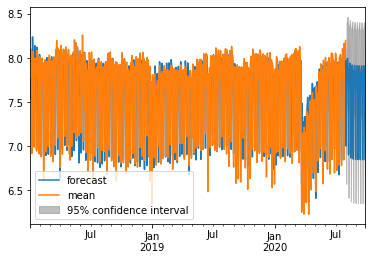

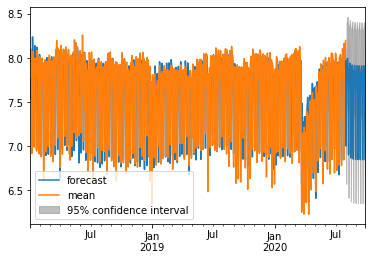

In [254]:
res.plot_predict(1,1000)

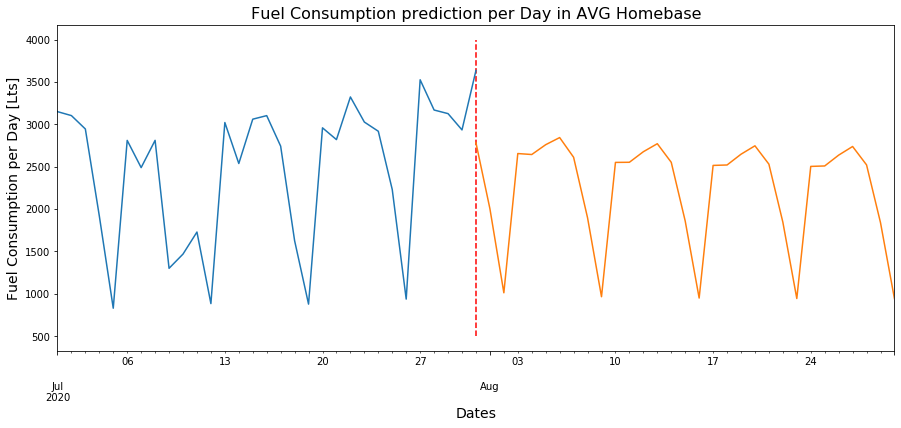

In [262]:
fig, ax = plt.subplots(figsize=(15, 6))
train.index = pd.to_datetime(train.index, format="%Y-%m-%d")
train.dropna()['2020-07'].plot(ax=ax)
ax.vlines('2020-07-31', 500, 4000, linestyle='--', color='r', label='Start of forecast')
np.exp(res.predict('2020-07-31', '2020-08-30', dynamic=True)).plot(ax=ax)
plt.title('Fuel Consumption prediction per Day in AVG Homebase', fontdict={'size':16})
plt.ylabel('Fuel Consumption per Day [Lts]', fontdict={'size':14})
plt.xlabel('Dates', fontdict={'size':14})
fig.savefig('./images/ARIMA_PREDICTIONS.png')